Compare the chip lists from the older and newer runs.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import pickle
repoDir= os.getcwd()
os.chdir(os.path.join(repoDir , '..' ))
repoDir= os.getcwd()

In [2]:
savedData= {}
filenames= ['extraneous/2017-04-06_chipPerVisitData_newAfterburnerOutput_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nonDiscRegion_nside512_187761TotChipsToSimulate.pickle']
for filename in filenames:
    key= 'Random_Both_nside512_new'
    with open('chipsPerVisitData/'+filename, 'rb') as handle:
        savedData[key]= pickle.load(handle)
        
filenames= ['previous used - bugged/2017-01-29_chipPerVisitData_newAfterburnerOutput_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nonDiscRegion_131052TotChipsToSimulate.pickle']
for filename in filenames:
    key= 'Random_Both_nside512_old'
    with open('chipsPerVisitData/'+filename, 'rb') as handle:
        savedData[key]= pickle.load(handle)
        
        
filenames= ['2017-04-06_chipPerVisitData_newAfterburnerOutput_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nonDiscRegion_nside1024_192103NonWFChipsToSimulate.pickle']
for filename in filenames:
    key= 'Random_Both_nside1024_new'
    with open('chipsPerVisitData/'+filename, 'rb') as handle:
        savedData[key]= pickle.load(handle)

All detectors include:
- 8 non-science sensors: 'R:0,0 S:1,2', 'R:0,0 S:2,1', 'R:0,4 S:1,0', 'R:0,4 S:2,1', 'R:4,0 S:0,1', 'R:4,0 S:1,2', 'R:4,4 S:0,1', 'R:4,4 S:1,0'
- 16 wavefront sensors: 'R:4,0 S:0,2,A', 'R:4,0 S:0,2,B','R:0,4 S:2,0,A', 'R:0,4 S:2,0,B', 'R:0,0 S:2,2,A', 'R:0,0 S:2,2,B', 'R:4,4 S:0,0,A', 'R:4,4 S:0,0,B'
           
           
^ which we are not simulating.

In [3]:
wavefront= ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B','R:0,4 S:2,0,A', 'R:0,4 S:2,0,B',
           'R:0,0 S:2,2,A', 'R:0,0 S:2,2,B','R:4,4 S:0,0,A', 'R:4,4 S:0,0,B']

nonScience= ['R:0,0 S:1,2', 'R:0,0 S:2,1', 'R:0,4 S:1,0', 'R:0,4 S:2,1', 
             'R:4,0 S:0,1', 'R:4,0 S:1,2', 'R:4,4 S:0,1', 'R:4,4 S:1,0']

In [4]:
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.utils import ObservationMetaData
from intermediates import getSimData, findRegionPixels
from numpy.lib.recfunctions import append_fields
from lsst.sims.coordUtils import getCornerRaDec

In [5]:
camera = LsstSimMapper().camera

In [6]:
# read in simdata
path= '/Volumes/Transcend/'
dbpath = path+'minion_1016_sqlite_new_dithers.db'   # new afterburner output
extraCols= ['expDate', 'obsHistID', 'ditheredRotTelPos', 'rotTelPos']
simdata= getSimData(dbpath, 'r', newAfterburner= True, extraCols= extraCols)

In [7]:
parallacticAngle= simdata['rotTelPos']-simdata['rotSkyPos'][:]
ditheredRotSkyPos= simdata['ditheredRotTelPos'][:]-parallacticAngle
simdata = append_fields(simdata, 'ditheredRotSkyPos', ditheredRotSkyPos,
                        dtypes= ditheredRotSkyPos.dtype, usemask=False, asrecarray=False)

In [8]:
stepsize = np.pi/50.
theta = np.arange(0, np.pi*2.+stepsize, stepsize)
radius= 0.0305

In [9]:
def getObsMetaData(pointingRACol,pointingDecCol, rotSkyCol):
    obsMetaData= {}  # key= hid

    for key in savedData.keys():
        for hid in np.unique(savedData[key]['obsHistID']):
            if hid not in obsMetaData.keys():
                inds= np.where(simdata['obsHistID']==hid)[0]
                for index in inds:
                    # for chip finding
                    pointingRA= simdata[index][pointingRACol] # radians
                    pointingDec= simdata[index][pointingDecCol] # radians
                    rotSkyPos= simdata[index][rotSkyCol] # radians
                    expMJD= simdata[index]['expMJD']
                    obsMetaData[hid] = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                                      rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
    return obsMetaData

In [10]:
pointingRACol= 'randomDitherFieldPerVisitRA'
pointingDecCol= 'randomDitherFieldPerVisitDec'
rotSkyCol= 'ditheredRotSkyPos'


obsMetaData= getObsMetaData(pointingRACol,pointingDecCol, rotSkyCol)

pointingRACol= 'fieldRA'
pointingDecCol= 'fieldDec'
rotSkyCol= 'rotSkyPos'

obsMetaData_undithered= getObsMetaData(pointingRACol,pointingDecCol, rotSkyCol)

In [11]:
import healpy as hp

nside= 512
def pixNum2RaDec(nside, pix):
    theta, phi = hp.pix2ang(pix, nside)
    return phi, np.pi/2.0-theta 

eh, eh, DC1Pixels= findRegionPixels(1447, simdata, nside= nside, disc= False, FOV_radius= 0.0305)
DC1pixRA, DC1pixDec= pixNum2RaDec(DC1Pixels, nside)

### See how the chip lists differs between older (Nside 512) and newer (Nside 1024) cases.

In [12]:
newData= 'Random_Both_nside1024_new'
oldData= 'Random_Both_nside512_old'

hIDs= []
missingList= []
missingCount= []
extraChipsList= []
extraChipsCounts= []
for hID in np.unique(simdata['obsHistID']):  # visit id in the new pickle
    i= np.where(savedData[newData]['obsHistID']==hID)[0]
    k= np.where(savedData[oldData]['obsHistID']==hID)[0]
    
    if (len(i)>0): # visit in the new list
        allNewChips= savedData[newData]['chipNames'][i]
        nonWFNewChips= list(set(allNewChips)-set(wavefront))
        goodNewChips= list(set(nonWFNewChips)-set(nonScience))
        if (len(k)>0): # visit was detected before
            allOldChips= savedData[oldData]['chipNames'][k]
            nonWFOldChips= list(set(allOldChips)-set(wavefront))
            goodOldChips= list(set(nonWFOldChips)-set(nonScience))

            missingChips= list(set(goodNewChips)-set(goodOldChips))
            extraChips= list(set(goodOldChips)-set(goodNewChips))
        else: # visit was never detected
            missingChips= goodNewChips
            extraChips= []
        
        hIDs.append(hID)
        missingList.append(missingChips)
        missingCount.append(len(missingChips))

        extraChipsList.append(extraChips)
        extraChipsCounts.append(len(extraChips))
        
    elif (len(k)>0):  # visit in the previous list but not in new 
        allOldChips= savedData[oldData]['chipNames'][k]
        nonWFOldChips= list(set(allOldChips)-set(wavefront))
        goodOldChips= list(set(nonWFOldChips)-set(nonScience))
        
        if (len(i)>0): # visit in the new list
            allNewChips= savedData[newData]['chipNames'][i]
            nonWFNewChips= list(set(allNewChips)-set(wavefront))
            goodNewChips= list(set(nonWFNewChips)-set(nonScience))

            missingChips= list(set(goodNewChips)-set(goodOldChips))
            extraChips= list(set(goodOldChips)-set(goodNewChips))

        else: # visit was never detected
            missingChips= []
            extraChips= goodOldChips
        hIDs.append(hID)
        missingList.append(missingChips)
        missingCount.append(len(missingChips)) 
        extraChipsList.append(extraChips)
        extraChipsCounts.append(len(extraChips))

/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


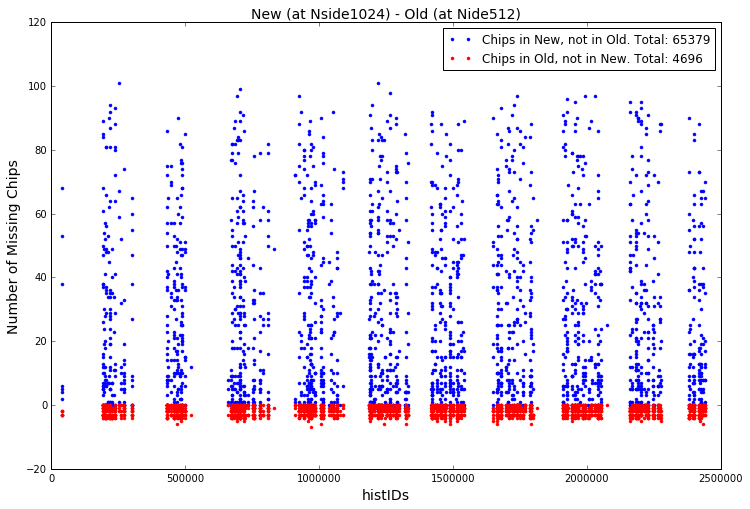

In [13]:
plt.plot(hIDs, missingCount, '.', color= 'b', label= 'Chips in New, not in Old. Total: %s'%(sum(missingCount)))
plt.plot(hIDs, -np.array(extraChipsCounts), '.', color= 'r', 
            label= 'Chips in Old, not in New. Total: %s'%(sum(extraChipsCounts)))
plt.legend()
plt.xlabel('histIDs', fontsize= 14)
plt.ylabel('Number of Missing Chips', fontsize= 14)
plt.title('New (at Nside1024) - Old (at Nide512)', fontsize= 14)

fig= plt.gcf()
fig.set_size_inches(12,8)
plt.show()

#### Plot the 'extra' chips (i.e. those in the older one but not the new one) to see whats happening.

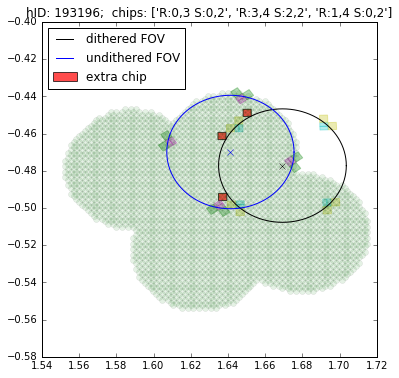

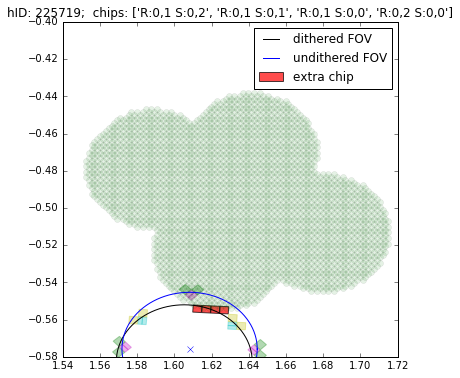

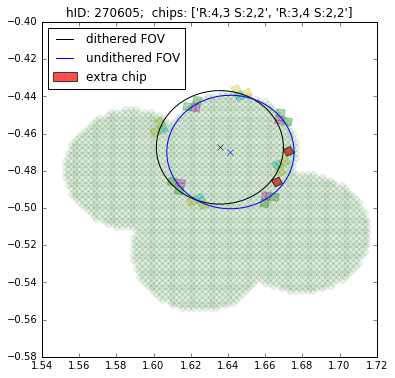

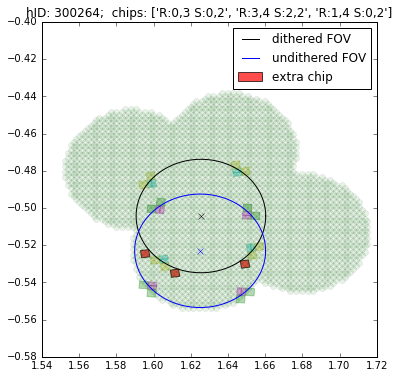

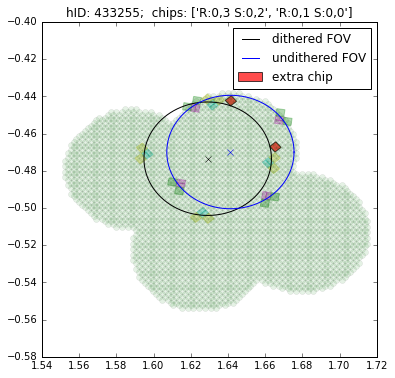

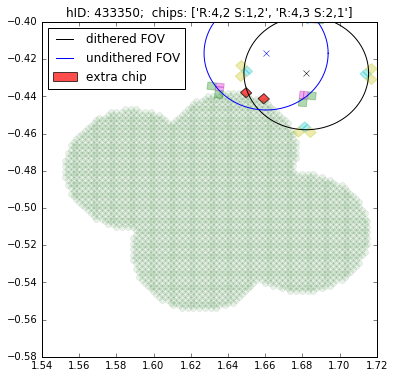

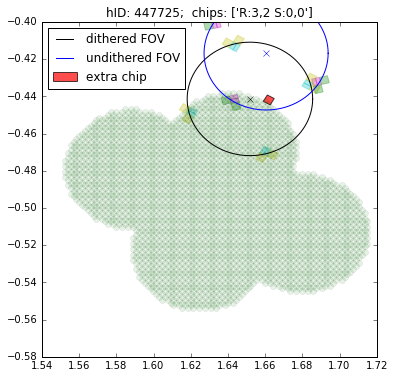

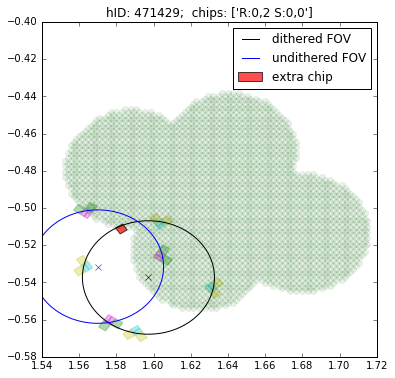

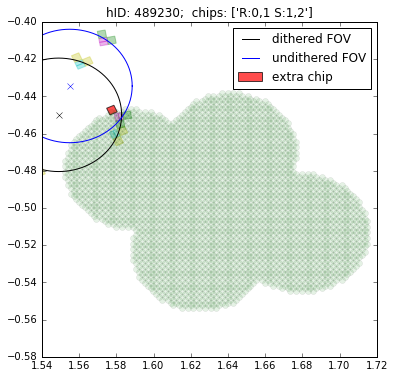

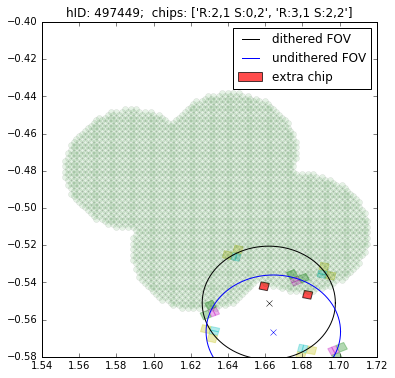

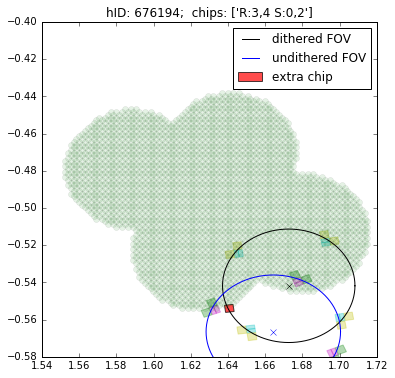

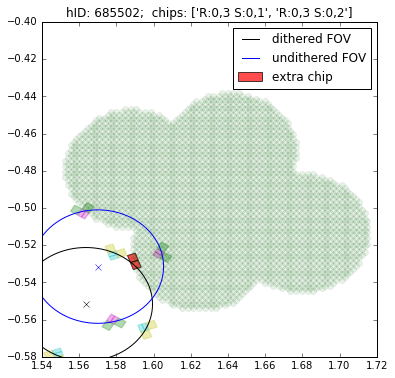

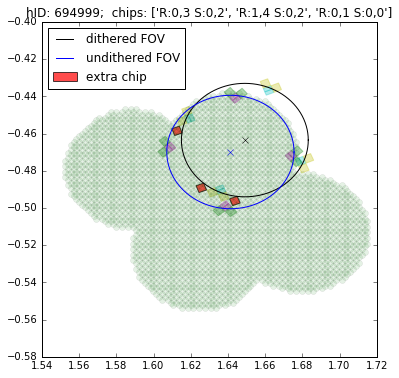

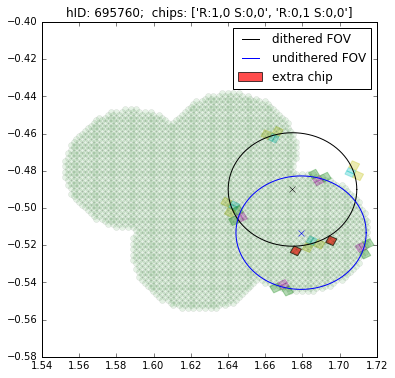

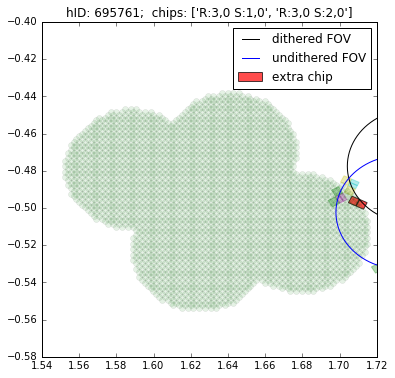

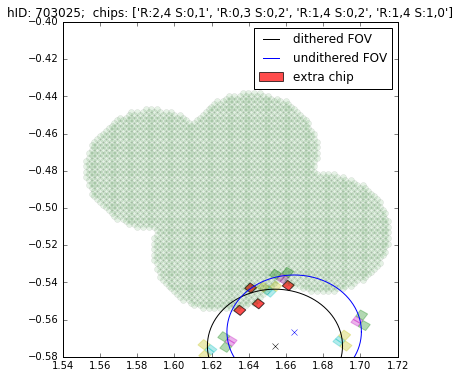

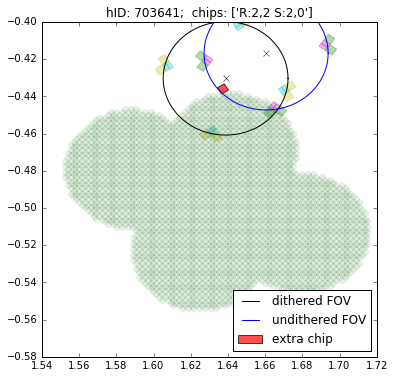

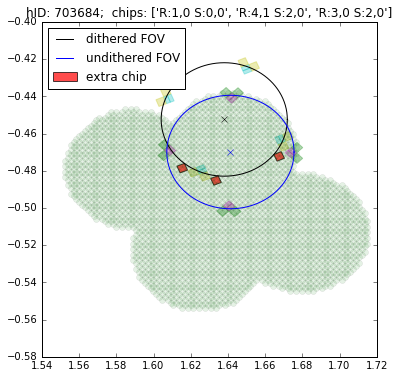

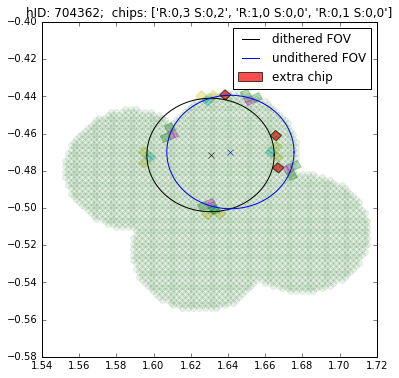

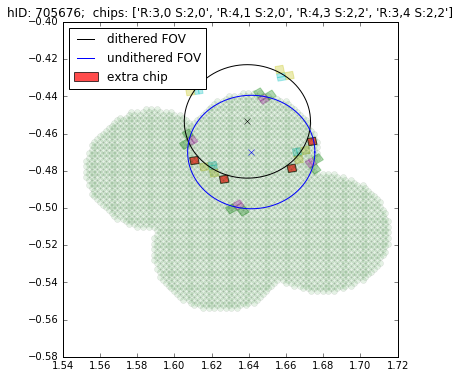

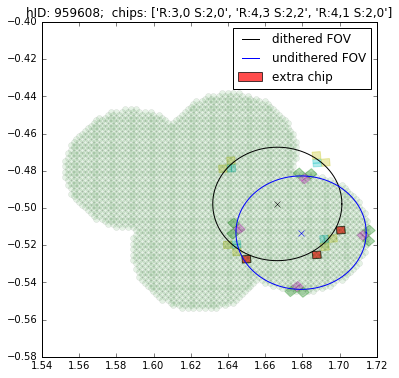

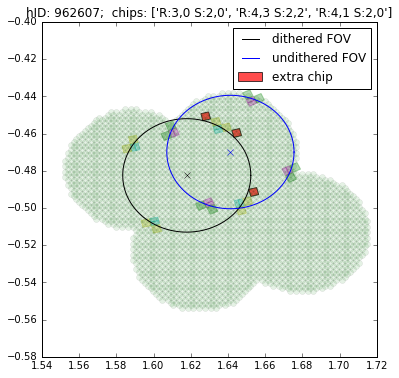

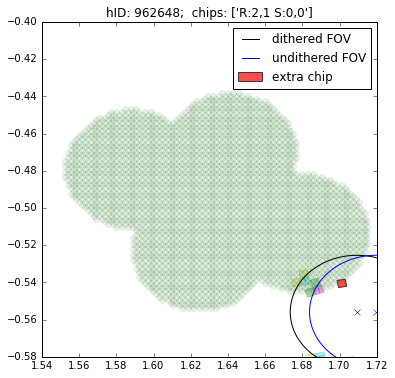

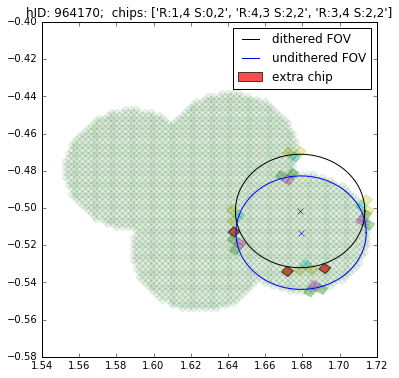

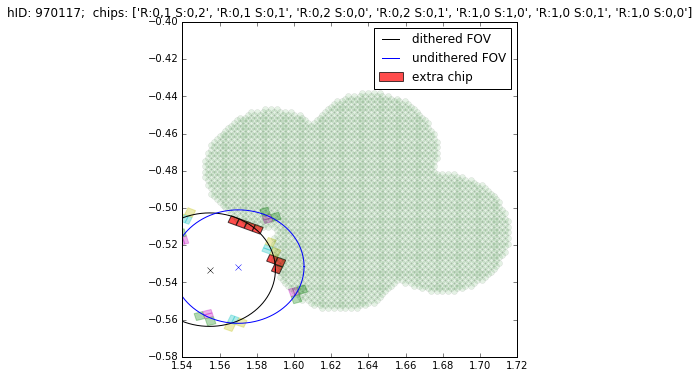

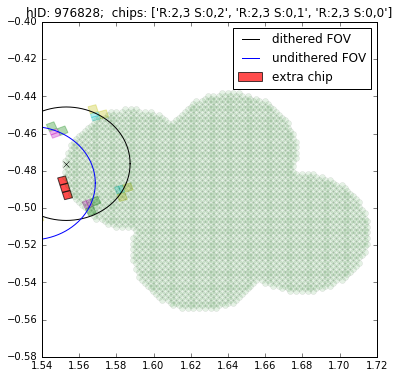

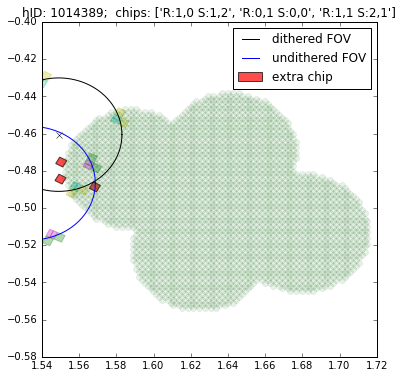

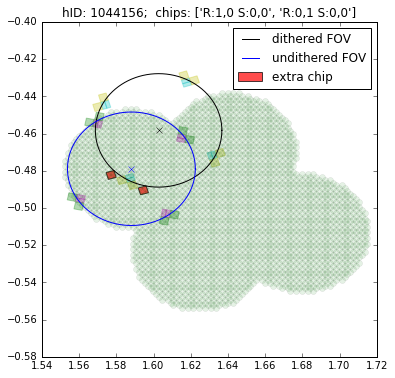

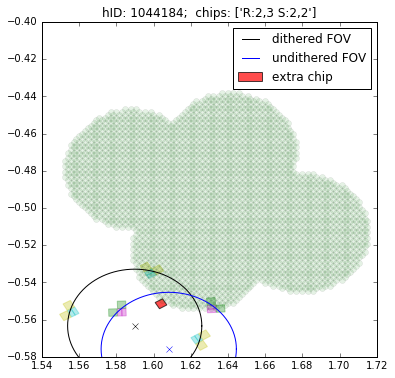

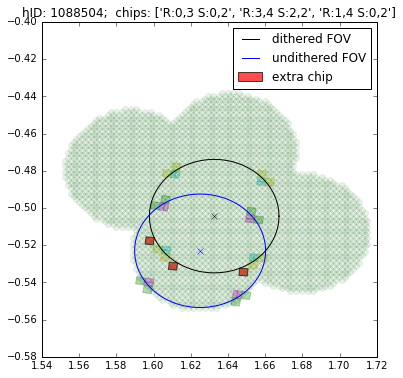

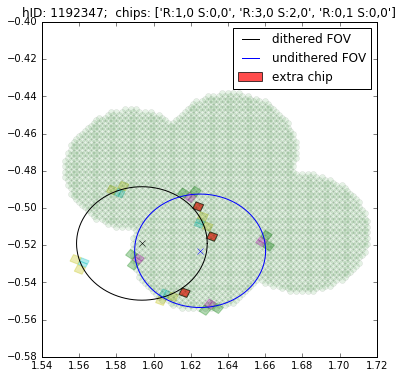

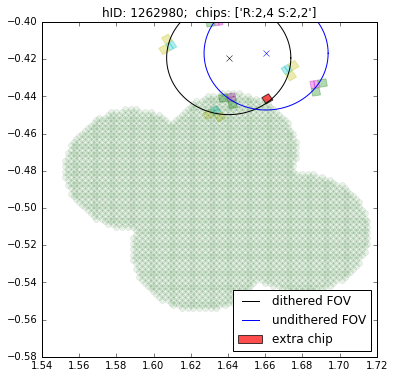

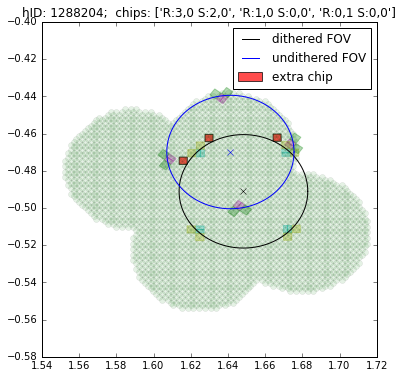

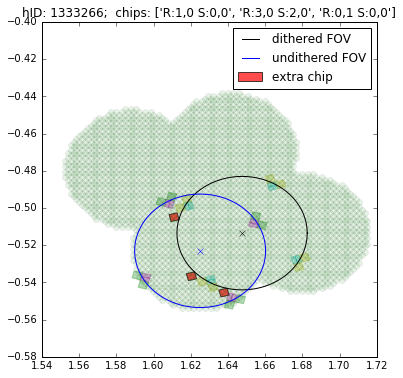

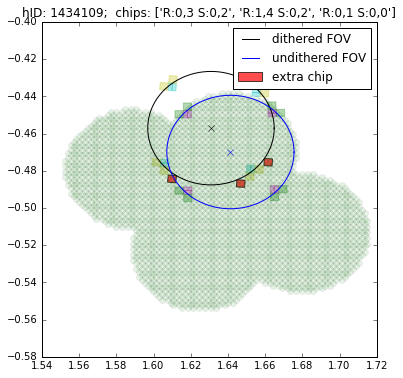

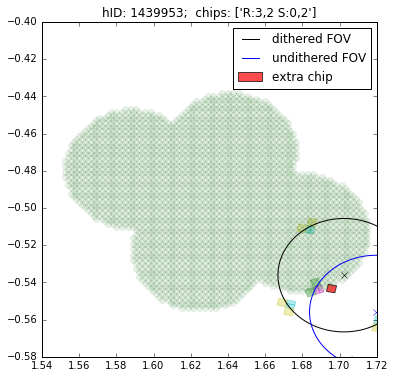

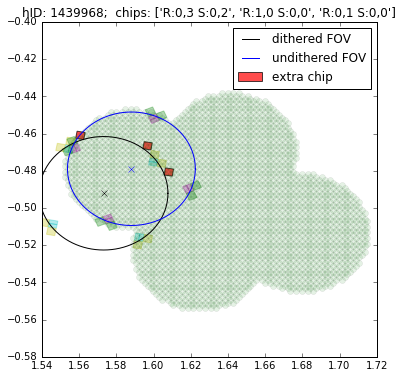

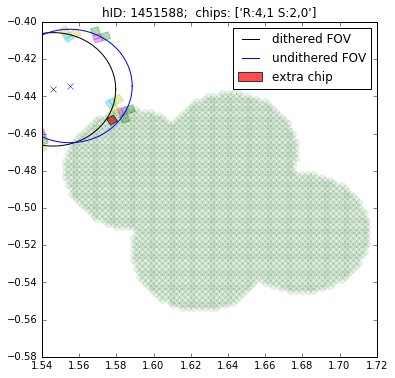

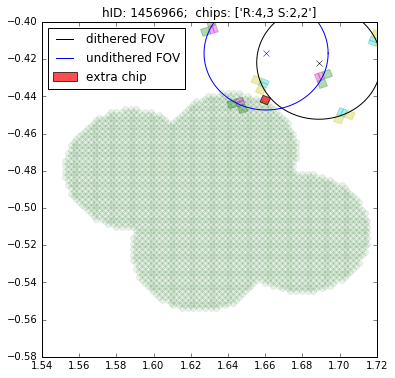

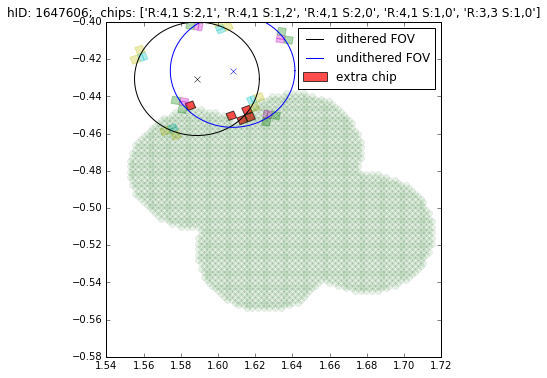

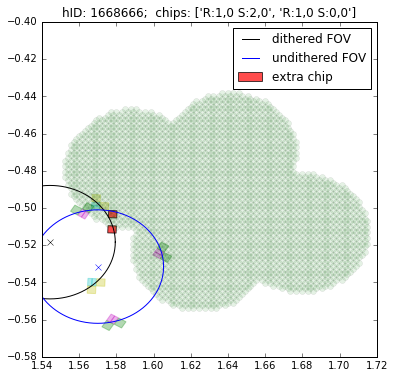

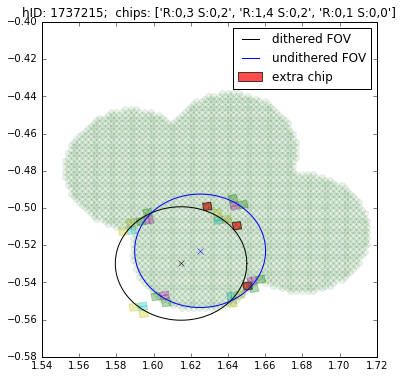

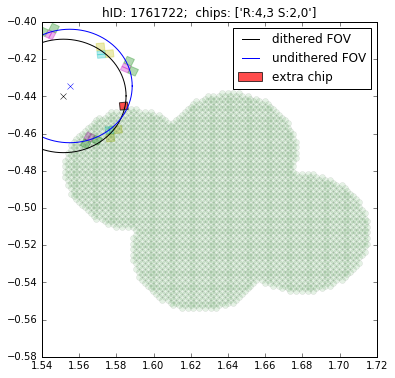

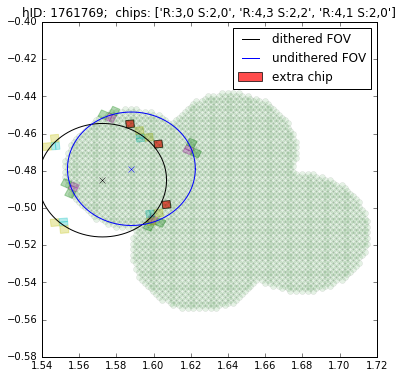

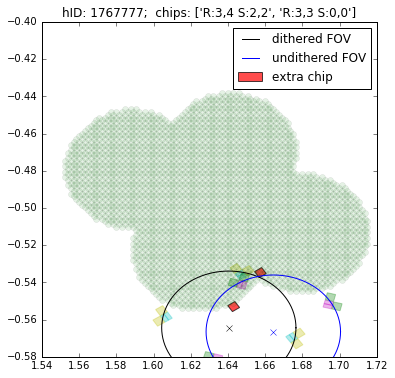

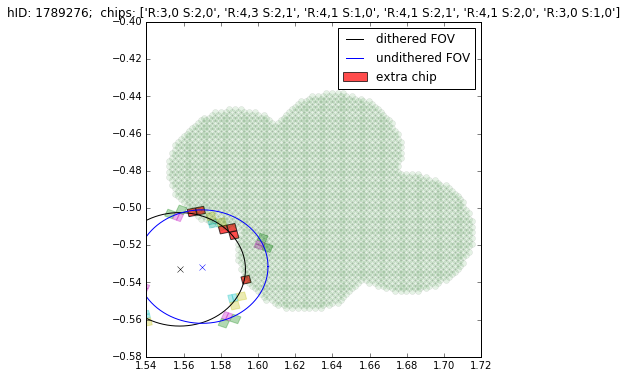

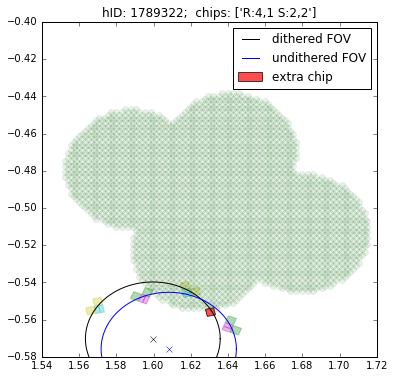

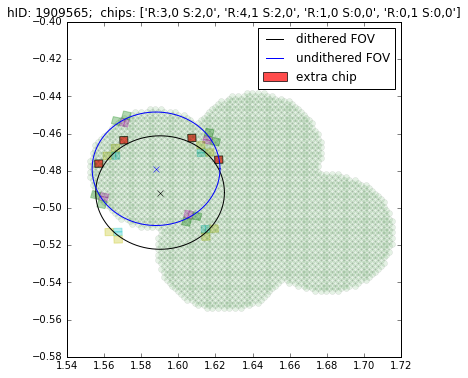

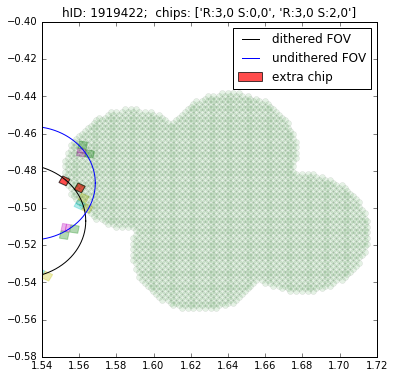

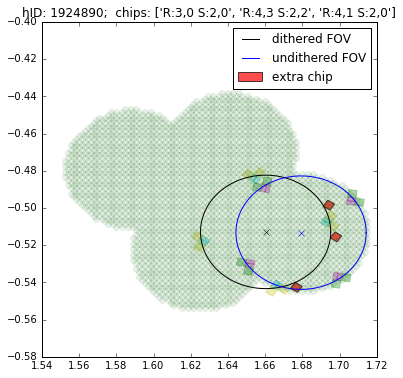

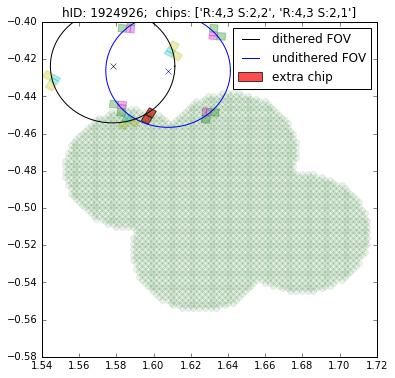

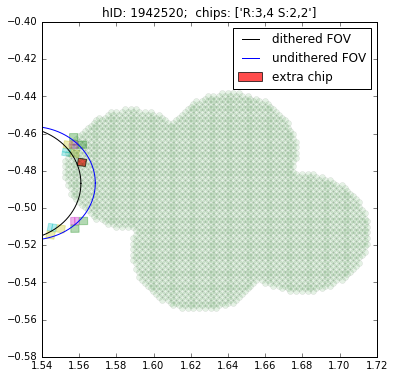

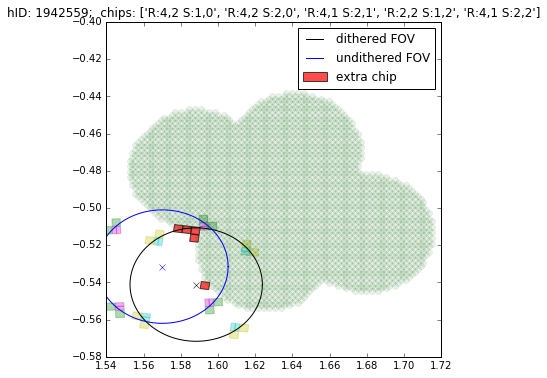

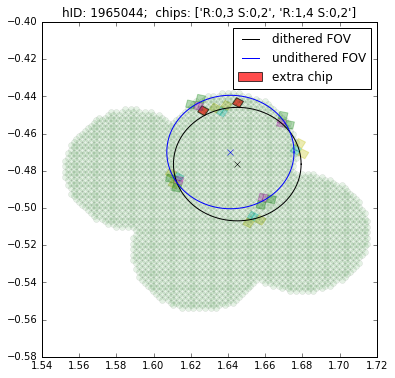

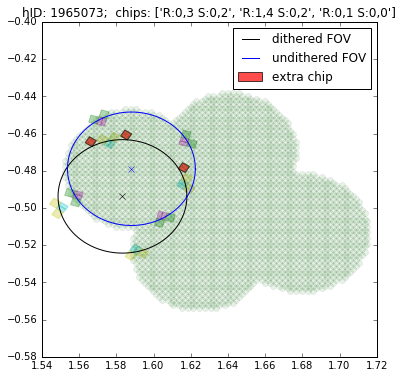

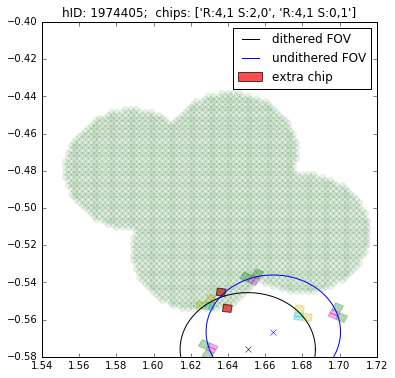

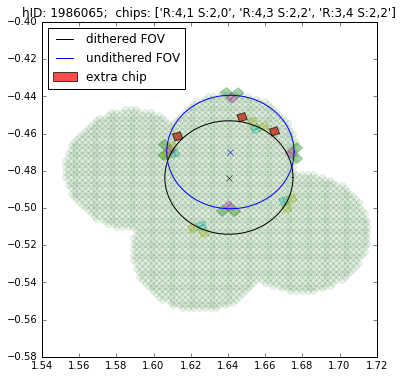

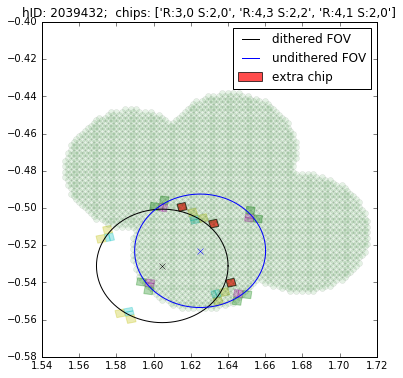

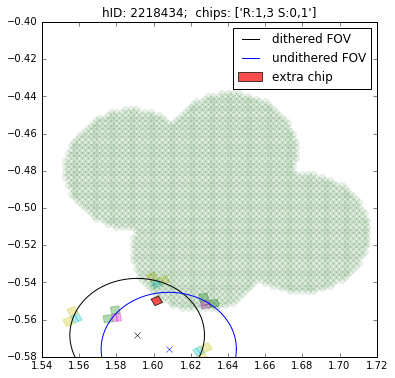

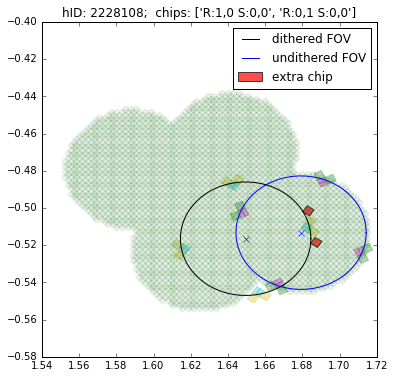

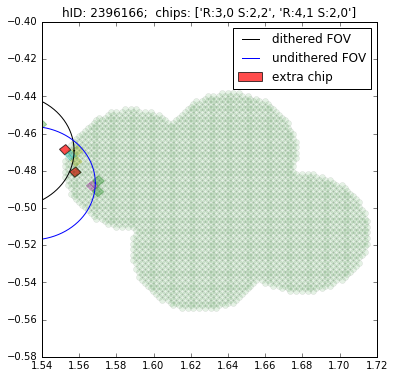

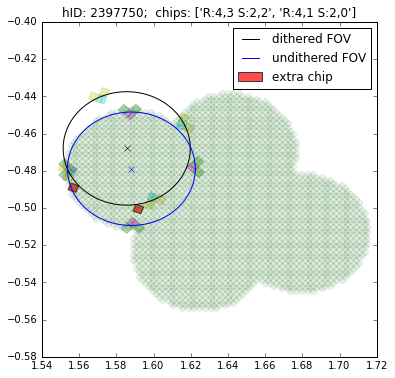

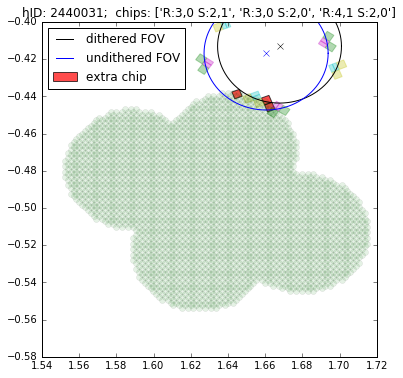

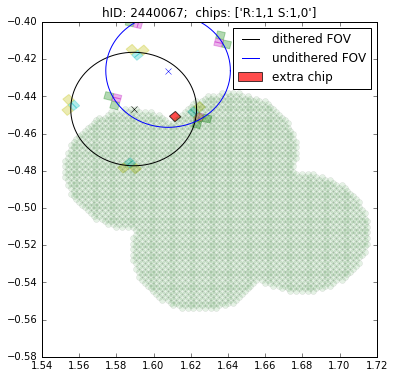

In [33]:
randind= np.sort(np.unique(np.random.randint(low= 0, high= len(extraChipsList), size= 75)))
extraChipsList= np.array(extraChipsList)
for i, chiplist in enumerate(extraChipsList[randind]):
    if len(chiplist)>0:
        hid= hIDs[randind[i]]
        fig, axes= plt.subplots(1,1)
        
        # plot the DC1 region
        axes.plot(DC1pixRA, DC1pixDec, 'o', color= 'g', alpha= 0.1)
        
        # plot the dithered FOV circle
        pointingRA, pointingDec= np.radians(obsMetaData[hid].pointingRA), np.radians(obsMetaData[hid].pointingDec)
        axes.plot(pointingRA, pointingDec, 'x', color= 'k')
        delx= radius*np.cos(theta)
        dely= radius*np.sin(theta)
        axes.plot(pointingRA+delx/np.cos(pointingDec), pointingDec+dely, color= 'k', label= 'dithered FOV')
        
        # plot the undithered FOV circle
        inds= np.where(simdata['obsHistID']==hid)[0]
        pointingRA= simdata[inds]['fieldRA'] # radians
        pointingDec= simdata[inds]['fieldDec'] # radians
        axes.plot(pointingRA, pointingDec, 'x', color= 'b')
        axes.plot(pointingRA+delx/np.cos(pointingDec), pointingDec+dely, color= 'b', label= 'undithered FOV')
            
        for j, extrachip in enumerate(chiplist):
            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(extrachip, camera, obsMetaData[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            
            label= ''
            if (j==0): label= 'extra chip'
            axes.fill(x,y, 'r', alpha=0.7, edgecolor='k', label= label)
            
        for chip in wavefront:
            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, obsMetaData[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            axes.fill(x,y, 'c', alpha=0.3, edgecolor='c')   # dithered

            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, 
                                                                                     obsMetaData_undithered[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            axes.fill(x,y, 'm', alpha=0.3, edgecolor='m')   # undithered

        for chip in nonScience:
            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, obsMetaData[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            axes.fill(x,y, 'y', alpha=0.3, edgecolor='y')

            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, 
                                                                                     obsMetaData_undithered[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            axes.fill(x,y, 'g', alpha=0.3, edgecolor='g')

        axes.axis('equal')
        factor= 0.00
        xmin, xmax= 1.54, 1.72
        ymin, ymax= -0.56, -0.42
        axes.set_xlim([xmin-factor, xmax+factor]) 
        axes.set_ylim([ymin-factor, ymax+factor])
        plt.legend(loc= "best")
        axes.set_title('hID: %s;  chips: %s'%(hid, chiplist))
        fig.set_size_inches(6,6)
        plt.show()

Ok the extra chips are either at the edges of the correct FOV (dithered) or at the edges of the DC1 region. Are really extraneous.

### See how the chip lists differs between older (Nside 512) and newer (Nside 1024) cases.

In [34]:
newData= 'Random_Both_nside1024_new'
oldData= 'Random_Both_nside512_new'


hIDs2= []
missingList2= []
missingCount2= []
extraChipsList2= []
extraChipsCounts2= []
for hID in np.unique(simdata['obsHistID']):  # visit id in the new pickle
    i= np.where(savedData[newData]['obsHistID']==hID)[0]
    k= np.where(savedData[oldData]['obsHistID']==hID)[0]
    
    if (len(i)>0): # visit in the new list
        allNewChips= savedData[newData]['chipNames'][i]
        nonWFNewChips= list(set(allNewChips)-set(wavefront))
        goodNewChips= list(set(nonWFNewChips)-set(nonScience))
        if (len(k)>0): # visit was detected before
            allOldChips= savedData[oldData]['chipNames'][k]
            nonWFOldChips= list(set(allOldChips)-set(wavefront))
            goodOldChips= list(set(nonWFOldChips)-set(nonScience))

            missingChips= list(set(goodNewChips)-set(goodOldChips))
            extraChips= list(set(goodOldChips)-set(goodNewChips))
        else: # visit was never detected
            missingChips= goodNewChips
            extraChips= []
        
        hIDs2.append(hID)
        missingList2.append(missingChips)
        missingCount2.append(len(missingChips))

        extraChipsList2.append(extraChips)
        extraChipsCounts2.append(len(extraChips))
        
    elif (len(k)>0):  # visit in the previous list but not in new 
        allOldChips= savedData[oldData]['chipNames'][k]
        nonWFOldChips= list(set(allOldChips)-set(wavefront))
        goodOldChips= list(set(nonWFOldChips)-set(nonScience))
        
        if (len(i)>0): # visit in the new list
            allNewChips= savedData[newData]['chipNames'][i]
            nonWFNewChips= list(set(allNewChips)-set(wavefront))
            goodNewChips= list(set(nonWFNewChips)-set(nonScience))

            missingChips= list(set(goodNewChips)-set(goodOldChips))
            extraChips= list(set(goodOldChips)-set(goodNewChips))

        else: # visit was never detected
            missingChips= []
            extraChips= goodOldChips


        hIDs2.append(hID)
        missingList2.append(missingChips)
        missingCount2.append(len(missingChips)) 
        extraChipsList2.append(extraChips)
        extraChipsCounts2.append(len(extraChips))

/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/Humna/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


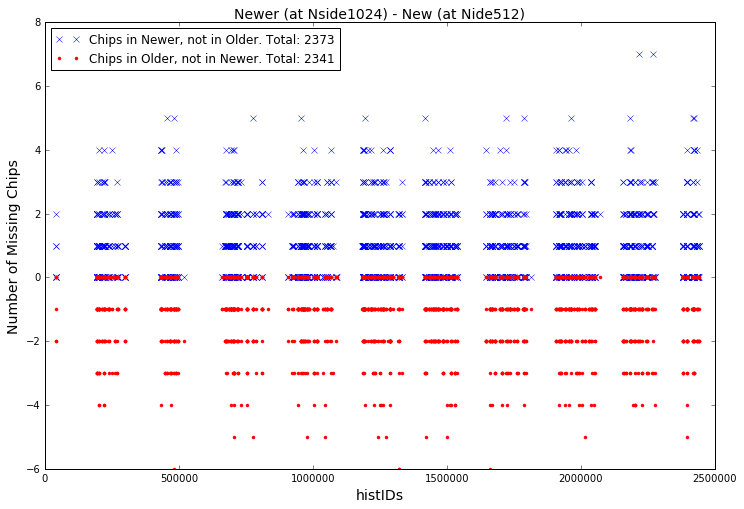

In [35]:
plt.plot(hIDs2, missingCount2, 'x', color= 'b', label= 'Chips in Newer, not in Older. Total: %s'%(sum(missingCount2)))
plt.plot(hIDs2, -np.array(extraChipsCounts2), '.', color= 'r', 
            label= 'Chips in Older, not in Newer. Total: %s'%(sum(extraChipsCounts2)))
plt.legend(loc= 2)
plt.xlabel('histIDs', fontsize= 14)
plt.ylabel('Number of Missing Chips', fontsize= 14)
plt.title('Newer (at Nside1024) - New (at Nide512)', fontsize= 14)
fig= plt.gcf()
fig.set_size_inches(12,8)
plt.show()

#### Plot the 'extra' chips for this case.

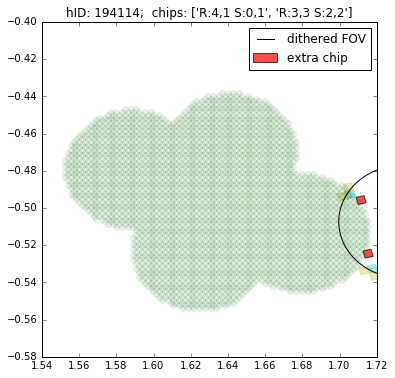

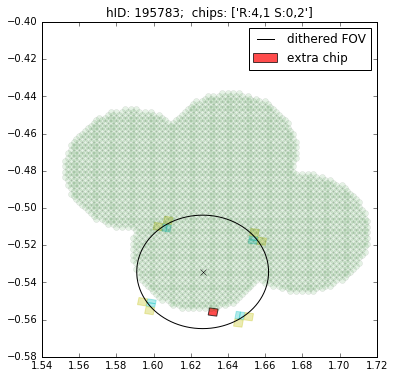

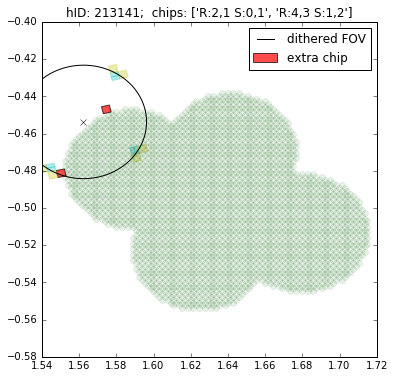

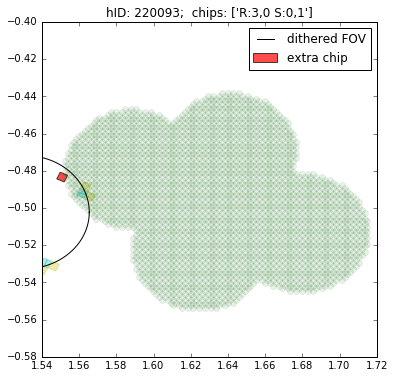

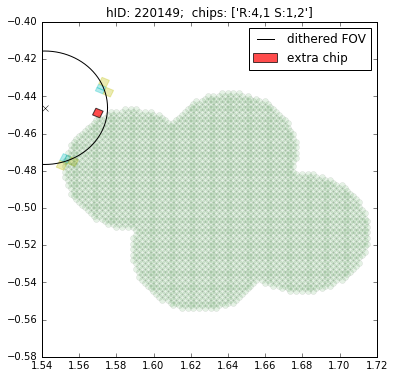

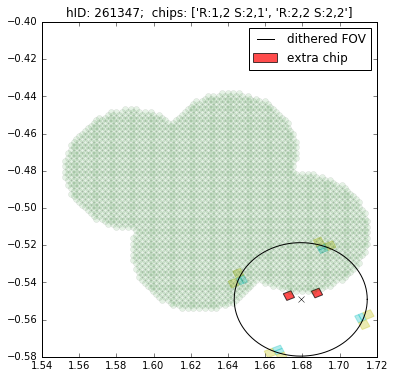

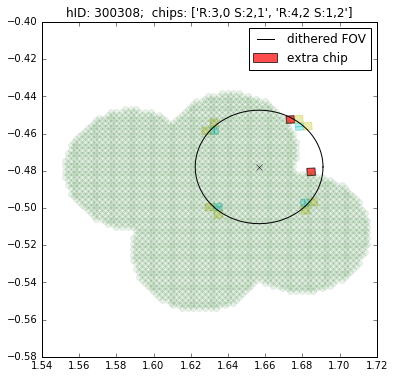

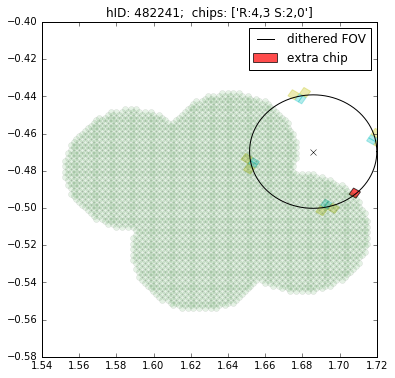

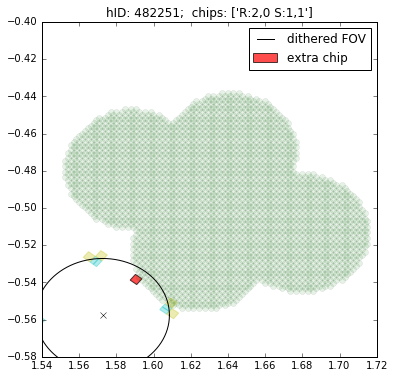

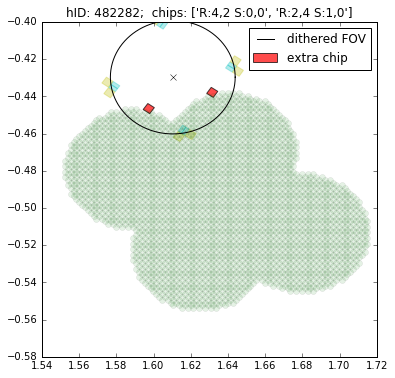

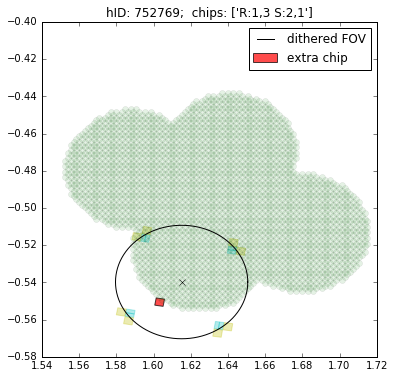

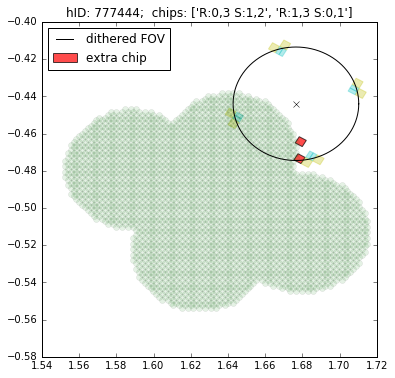

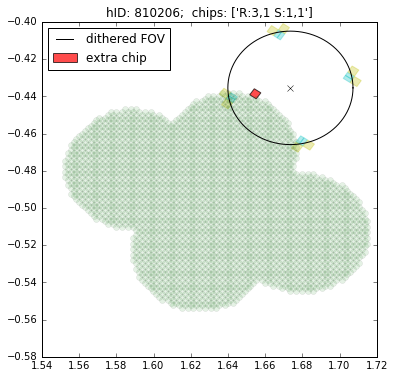

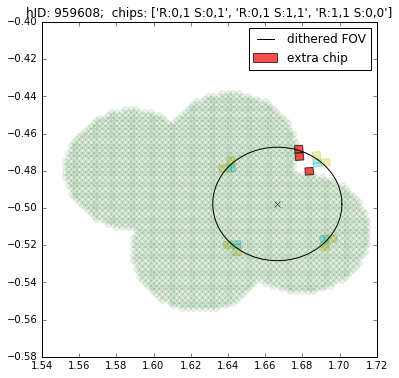

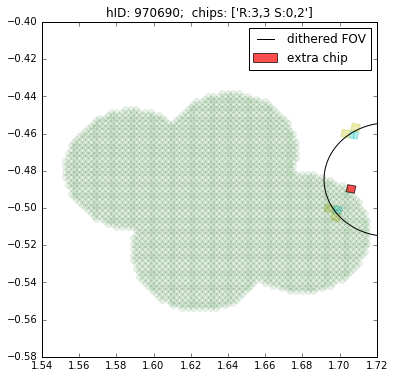

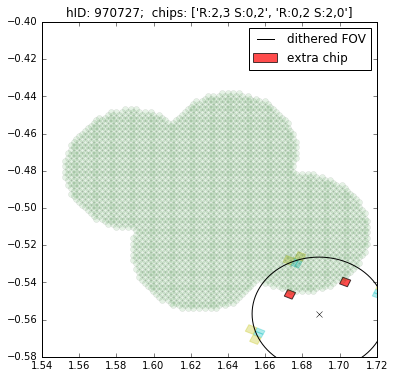

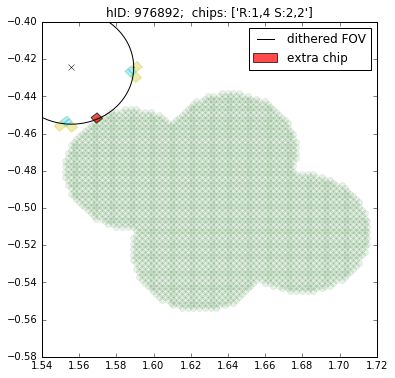

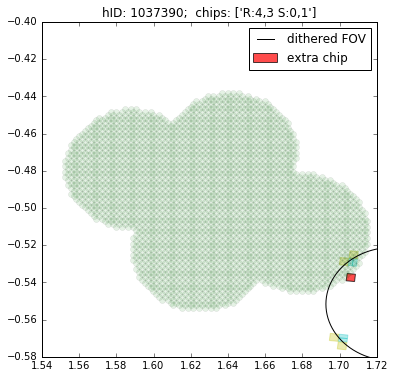

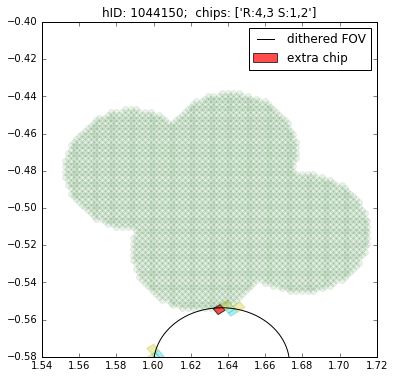

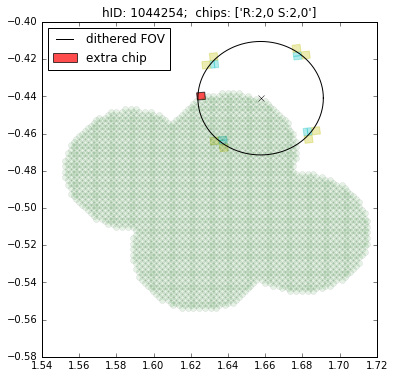

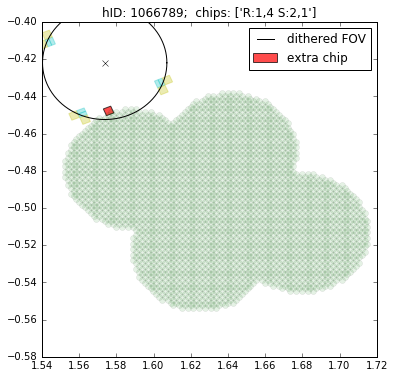

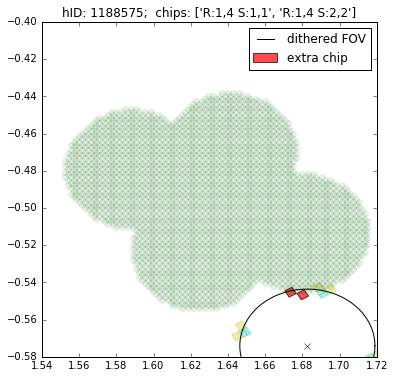

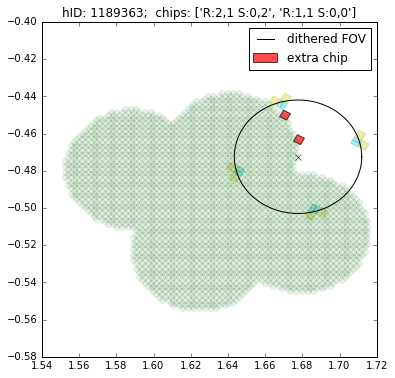

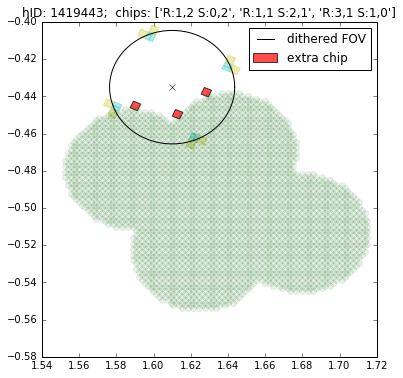

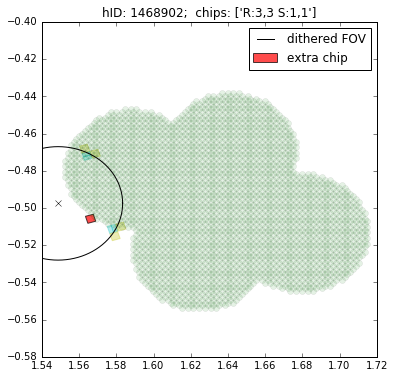

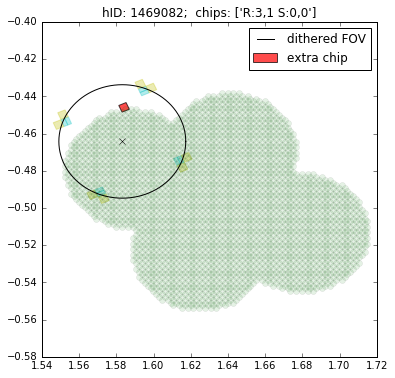

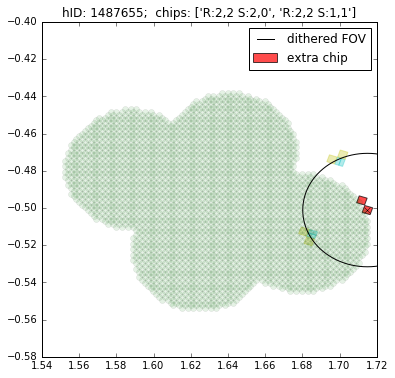

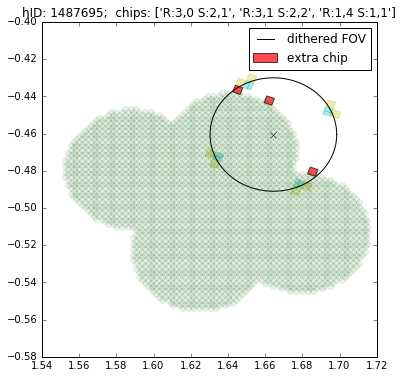

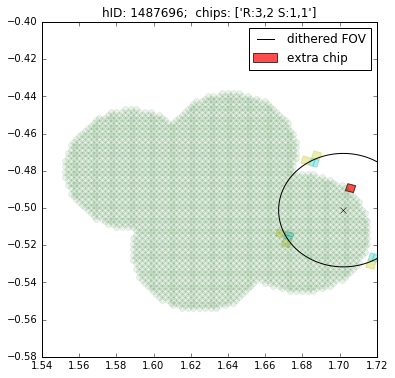

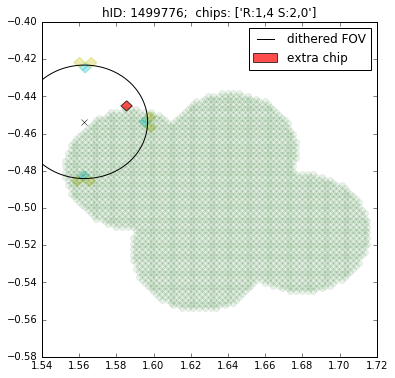

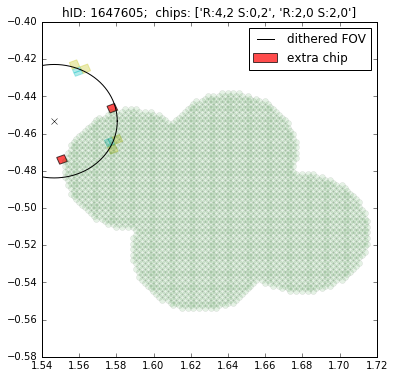

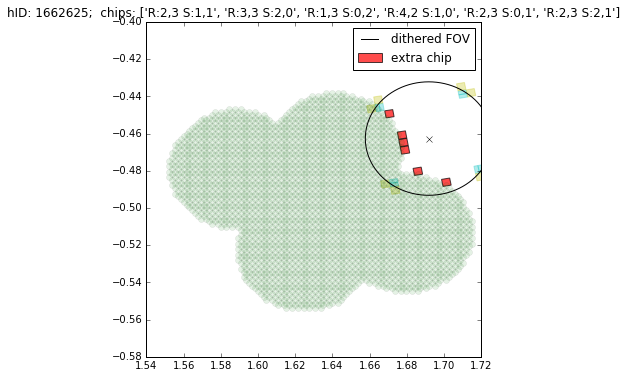

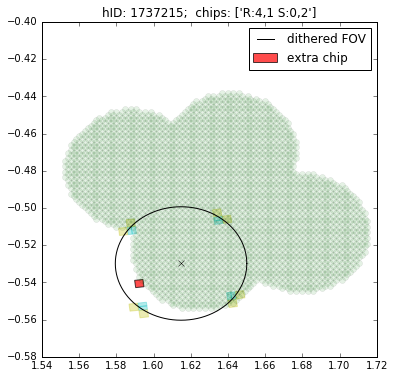

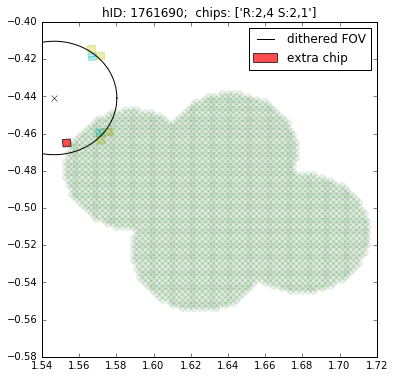

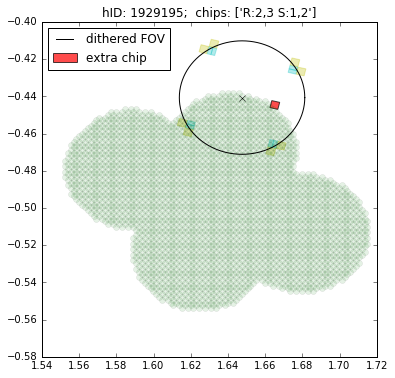

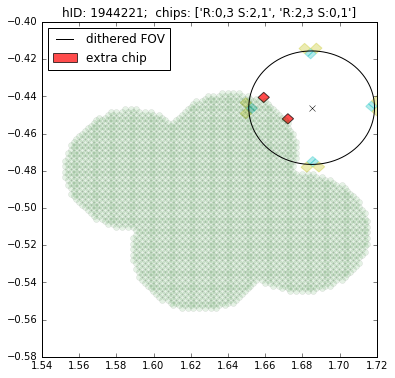

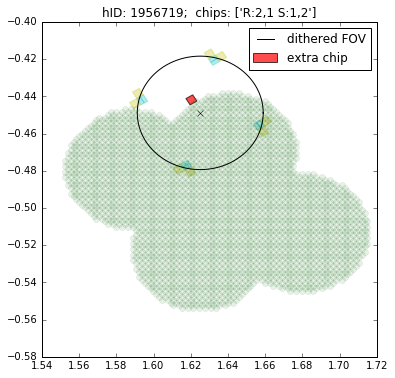

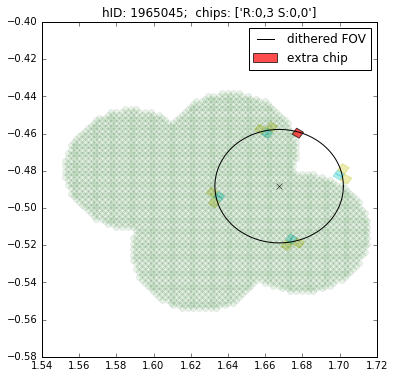

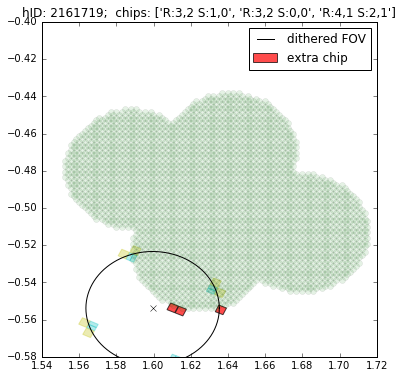

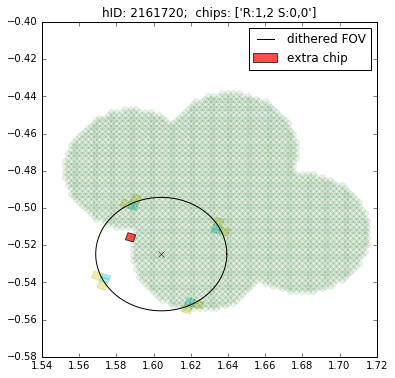

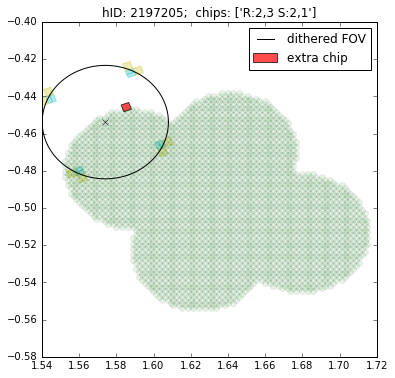

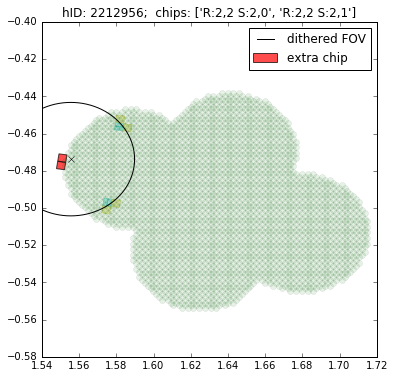

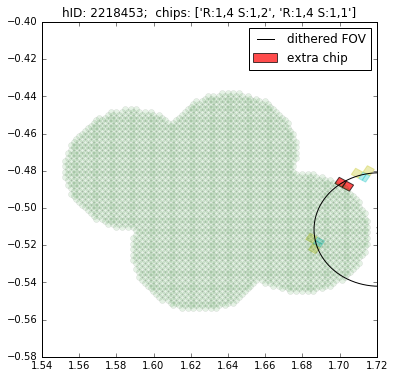

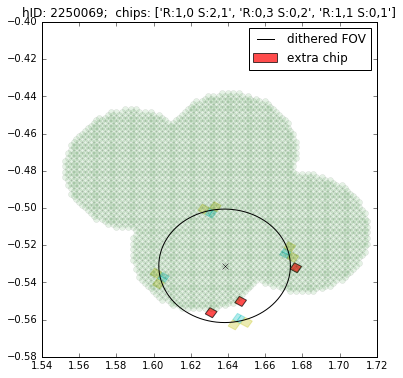

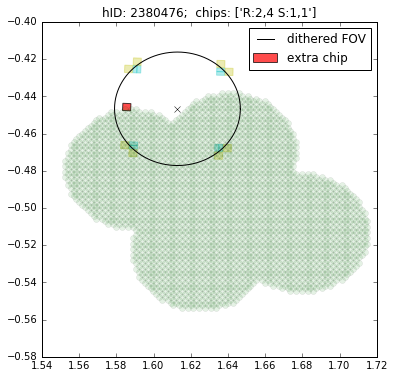

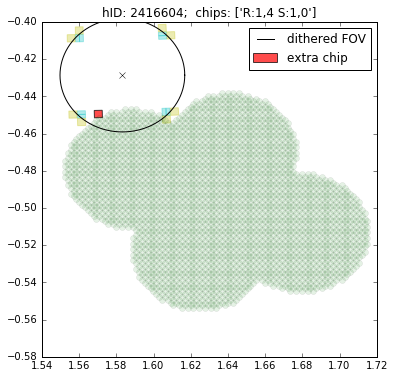

In [37]:
randind= np.sort(np.unique(np.random.randint(low= 0, high= len(extraChipsList2), size= 75)))
extraChipsList2= np.array(extraChipsList2)
for i, chiplist in enumerate(extraChipsList2[randind]):
    if len(chiplist)>0:        
        hid= hIDs2[randind[i]]
        fig, axes= plt.subplots(1,1)
        
        # plot the DC1 region
        axes.plot(DC1pixRA, DC1pixDec, 'o', color= 'g', alpha= 0.1)
        
        # plot the dithered FOV circle
        pointingRA, pointingDec= np.radians(obsMetaData[hid].pointingRA), np.radians(obsMetaData[hid].pointingDec)
        axes.plot(pointingRA, pointingDec, 'x', color= 'k')
        delx= radius*np.cos(theta)
        dely= radius*np.sin(theta)
        axes.plot(pointingRA+delx/np.cos(pointingDec), pointingDec+dely, color= 'k', label= 'dithered FOV')
            
        for j, extrachip in enumerate(chiplist):
            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(extrachip, camera, obsMetaData[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            
            label= ''
            if (j==0): label= 'extra chip'
            axes.fill(x,y, 'r', alpha=0.7, edgecolor='k', label= label)
            
        for chip in wavefront:
            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, obsMetaData[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            axes.fill(x,y, 'c', alpha=0.3, edgecolor='c')   # dithered

        for chip in nonScience:
            x, y= np.zeros(5), np.zeros(5)
            [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, obsMetaData[hid])
            x[4], y[4]= x[0], y[0]        
            x, y= np.deg2rad(x), np.deg2rad(y)
            axes.fill(x,y, 'y', alpha=0.3, edgecolor='y')

        axes.axis('equal')
        factor= 0.00
        xmin, xmax= 1.54, 1.72
        ymin, ymax= -0.56, -0.42
        axes.set_xlim([xmin-factor, xmax+factor]) 
        axes.set_ylim([ymin-factor, ymax+factor])
        plt.legend(loc= "best")
        axes.set_title('hID: %s;  chips: %s'%(hid, chiplist))
        fig.set_size_inches(6,6)
        plt.show()

Ok the extra chips are at the edges of the DC1 region. Understandable given the change in resolution.